In [1]:
import numpy as np
import time
import math
import modules as md
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches




#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newton 

In [56]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;


# PN 

In [57]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector

    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum()
                v2d = (vrel**2).sum()
                a1[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel)
                a2[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*(runi*(ruvd)*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d))
                a[i] += a1[i] + a2[i] #a1[i] +  
    return a#, a1, a2 # return acceleration


#PN Jerk v2

def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO3v2 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*arel).sum()                                                  
                vad = (vrel*arel).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt 

# Static Tides 

In [58]:
def acctide(r,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rvec = r[i,:]-r[j,:]
                ra = ((rvec**2).sum())**(1./2) #dot product
                runi = rvec/ra
                a[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(runi)/(ra**7.0) #Acceleration at each time step 
    return a # return acceleration

def Jerktide(r,v,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Je[i] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( vrel/rn**8.0 - 8.*((vrel*rrel).sum())*(rrel)/(rn**10.0) ) 
    return Je;



# Dynamical Tides 

In [59]:
def accdytide(r,v,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3))
    a2 = np.zeros((len(r),3))
    a3 = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                vn = ((vrel**2).sum())**(1./2)
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a1[i] += -(36.)*ne[i]*((m[j]**2)/m[i])*(runi)*(vn**2)/(rn**9.0) #Acceleration at each time step 
                a2[i] += -(90.)*ne[i]*((m[j]**2)/m[i])*(runi)*((runi*vrel).sum()**2)/(rn**9.0)
                a3[i] += +(18.)*ne[i]*((m[j]**2)/m[i])*(vrel)*((runi*vrel).sum())/(rn**9.0)
                a[i] += a1[i] + a2[i] + a3[i]
    return a # return acceleration


def Jerkdytide(r,v, a, m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    Je3 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                arel = (a[i]-a[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                vn = ((vrel**2).sum())**(1./2)
                Je1[i] += - (36.0)*ne[i]*((m[j]**2)/m[i])*( vrel*(vn**2)/rn**(10.0) - 10.*(vn**2)*((vrel*rrel).sum())*(rrel)/(rn**12.0) + 72*((vrel*arel).sum())/(rn**9.0) )
                Je2[i] += -(90.)*ne[i]*((m[j]**2)/m[i])*((2*((rrel*vrel).sum())*( (arel*vrel).sum() + vn**2 )*rrel + vrel*((rrel*vrel).sum()**2))/(rn**12.) - (12*((rrel*vrel).sum()**3)*rrel )/(rn**14.) )
                Je3[i] += +(18.)*ne[i]*((m[j]**2)/m[i])*( (arel*((rrel*vrel).sum()) + vrel*( (rrel*arel).sum() + vn**2 ) )/(rn**10.)  -10*vrel*((rrel*vrel).sum()**2)/(rn**12.)  )
                Je[i] = Je1[i] + Je2[i] + Je3[i]
    return Je;

# previous version

def accdytide(r,v,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                vn = ((vrel**2).sum())**(1./2)
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a[i,:] += -(36.)*ne[i]*((m[j]**2)/m[i])*(runi)*(vn**2)/(rn**9.0) #Acceleration at each time step 
    return a # return acceleration


def Jerkdytide(r,v, a, m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                vn = ((vrel**2).sum())**(1./2)
                Je[i,:] += - (36.0)*ne[i]*((m[j]**2)/m[i])*( vrel*(vn**2)/rn**(10.0) - 10.*(vn**2)*((vrel*rrel).sum())*(rrel)/(rn**12.0) + 72*((vrel*a[i]).sum())/(rn**9.0) ) 
                #ra = (((r[i,:]-r[j,:])**2).sum())**(1./2) # dot product
                #Je[i,:] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( (v[i,:]-v[j,:])/ra**8.0 - 8.*(((v[i,:]-v[j,:])*(r[i,:]-r[j,:])).sum())*(r[i,:]-r[j,:])/(ra**10.0) ) 
    return Je;


# Hermite Integrator with PN and Oscillations 

In [60]:
def HermiteUpdatePNdytidedt(dt, r, v, m, ns, no): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    aO = accdytide(r, v, m, no)
    aPN = accPN(r, v, m)
    a = aN + aPN + aT + aO # current acceleration
    
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    aOdot = Jerkdytide(r, v, a, m, no)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot + aTdot + aOdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aTp = acctide(rp, m, ns)
    aOp = accdytide(rp, vp, m, no)
    ap = aNp + aPNp + aTp +aOp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    aOdotp = Jerkdytide(rp, vp, ap, m, no)
    adotp = aNdotp + aPNdotp +  aTdotp + aOdotp
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp+adot)

 
    return rc,vc,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNdytidedt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    #aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    #a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    ndtidev = np.array([pri.ndtide, sec.ndtide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNdytidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev, ndtidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    #a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    #aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [102]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
bh3nscol = md.Binary(bh3, ns, ns.radi*10, 0) ##primary, secondary, orbital distance (Rsun), eccentricity

In [103]:
print(ns.ntide)
print(ns.ndtide)
print(bh3.eta)


13917.65663191198
3663553.5560266846
34911.810528585214


# Run a series of simulations with dt = 0.01  

In [104]:
tl = 9*bh3nscol.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.01 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

In [105]:
rPNTO,vPNTO,timePNTO = Hermite4thPNdytidedt(bh3,ns, bh3nscol, Nsteps, dt)

In [106]:
print(timePNTO)

[0.000000e+00 1.000000e-02 2.000000e-02 ... 1.239590e+04 1.239591e+04
 1.239592e+04]


No handles with labels found to put in legend.


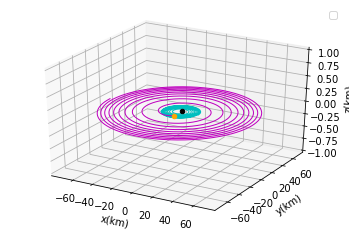

In [107]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNTO[0][0], rPNTO[0][1], rPNTO[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNTO[1][0], rPNTO[1][1], rPNTO[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNTO[0][0][-1], rPNTO[0][1][-1], rPNTO[0][2][-1], '0', c='black') #s=100 markersize=40
ax.scatter3D(rPNTO[1][0][-1], rPNTO[1][1][-1], rPNTO[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
ax.set_zlim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('TPNcol.png', bbox_inches='tight', dpi=300)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [108]:
rrelPNTO = rPNTO[0] - rPNTO[1]
vrelPNTO = vPNTO[0] - vPNTO[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNTO = np.zeros(len(rrelPNTO .T)) 

for i in range(len(rrelPNTO.T)):
    dPNTO[i] = np.linalg.norm(rrelPNTO.T[i])
    
#Obtain the relative velocity
vnPNTO = np.zeros(len(vrelPNTO.T)) 

for i in range(len(vrelPNTO.T)):
    vnPNTO[i] = np.linalg.norm(vrelPNTO.T[i])

In [109]:
vnPNTOkm = vnPNTO/kmsec_U*1000/c_SI
timePNTOsec = timePNTO*time_U

In [110]:
wsPNTO = np.zeros([len(dPNTO)])

for i in range(len(dPNTO)):
    wsPNTO[i] = ((ns.mass+bh3.mass)/dPNTO[i]**3)**(1./2) 
    
hplusPNTO = np.zeros([len(dPNTO)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(ns.mass+bh3.mass)

for i in range(len(dPNTO)):
    hplusPNTO[i] = (1./ro)*(4*mu*(wsPNTO[i]**2)*(dPNTO[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNTO[i]*timePNTO[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

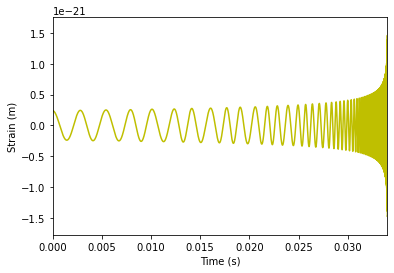

In [111]:
plt.plot(timePNTOsec, hplusPNTO, 'y-')
plt.axis([min(timePNTO), max(timePNTOsec), 1.2*min(hplusPNTO), 1.2*max(hplusPNTO)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# PN and Static effects 

In [112]:
def HermiteUpdatePNtidedt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN + aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot + aTdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aTp = acctide(rp, m, ns)
    ap = aNp + aPNp + aTp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp +  aTdotp  # predicted jerks 
    

    dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtidedt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    #aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    #a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    #a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    #aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [113]:
rPNT,vPNT,timePNT = Hermite4thPNtidedt(bh3,ns, bh3nscol, Nsteps, dt)

In [114]:
print(timePNT)

[0.000000e+00 1.000000e-02 2.000000e-02 ... 1.241269e+04 1.241270e+04
 1.241271e+04]


No handles with labels found to put in legend.


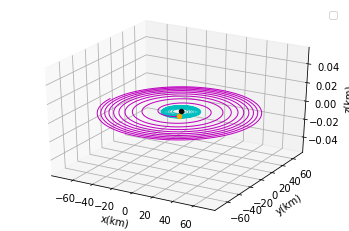

In [115]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNT[0][0], rPNT[0][1], rPNT[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNT[1][0], rPNT[1][1], rPNT[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNT[0][0][-1], rPNT[0][1][-1], rPNT[0][2][-1], '0', c='black') #s=100 markersize=40
ax.scatter3D(rPNT[1][0][-1], rPNT[1][1][-1], rPNT[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('TPNcol.png', bbox_inches='tight', dpi=300)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [116]:
rrelPNT = rPNT[0] - rPNT[1]
vrelPNT = vPNT[0] - vPNT[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNT = np.zeros(len(rrelPNT .T)) 

for i in range(len(rrelPNT.T)):
    dPNT[i] = np.linalg.norm(rrelPNT.T[i])
    
#Obtain the relative velocity
vnPNT = np.zeros(len(vrelPNT.T)) 

for i in range(len(vrelPNT.T)):
    vnPNT[i] = np.linalg.norm(vrelPNT.T[i])

In [117]:
vnPNTkm = vnPNT/kmsec_U*1000/c_SI
timePNTsec = timePNT*time_U

In [118]:
wsPNT = np.zeros([len(dPNT)])

for i in range(len(dPNT)):
    wsPNT[i] = ((ns.mass+bh3.mass)/dPNT[i]**3)**(1./2) 

hplusPNT = np.zeros([len(dPNT)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(ns.mass+bh3.mass)

for i in range(len(dPNT)):
    hplusPNT[i] = (1./ro)*(4*mu*(wsPNT[i]**2)*(dPNT[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNT[i]*timePNT[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

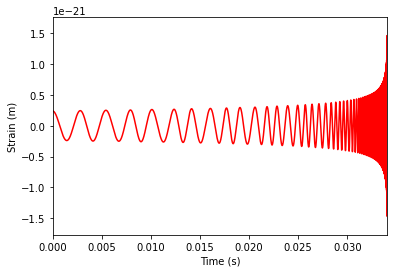

In [119]:
plt.plot(timePNTsec, hplusPNT, 'r-')
plt.axis([min(timePNT), max(timePNTsec), 1.2*min(hplusPNT), 1.2*max(hplusPNT)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Comparison of Waveforms 

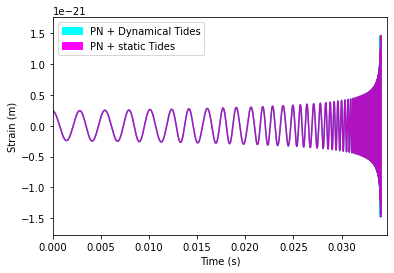

In [120]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + static Tides')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.plot(timePNTsec, hplusPNT, 'm-', alpha = 0.9)
plt.axis([min(timePNTsec), 1.02*max(timePNTsec), 1.2*min(hplusPNT), 1.2*max(hplusPNT)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-TOPNvsTPN.png', bbox_inches='tight', dpi=200) #, dpi=300
plt.show()

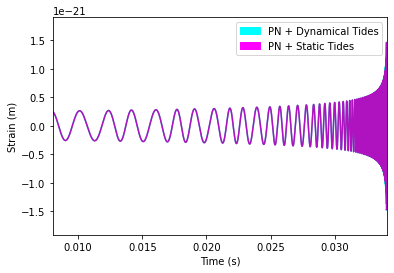

In [121]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Static Tides')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.plot(timePNTsec, hplusPNT, 'm-', alpha = 0.9)
plt.axis([0.008, 1.001*max(timePNTsec), 1.3*min(hplusPNT), 1.3*max(hplusPNT)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-TOPNvsTPN2.png', bbox_inches='tight', dpi=200) #, dpi=300
plt.show()

In [122]:
print(len(timePNT))
print(len(timePNTO))

1241272
1239593


In [123]:
print(timePNT[-1])
print(timePNTO[-1])
print(timePNTO[-1]/timePNT[-1])
print(timePNT[-1] - timePNTO[-1])

12412.71000022452
12395.920000224154
0.9986473542038714
16.79000000036649


In [124]:
print(timePNT[-1])
print(timePNTO[-1])
print(timePNTO[-1]/timePNT[-1])
print(timePNT[-1] - timePNTO[-1])

12412.71000022452
12395.920000224154
0.9986473542038714
16.79000000036649


# Only PN 

In [125]:
def HermiteUpdatePNtdt(dt, r, v, m): # m mass of the star
    
    aN = acc(r, m) 
    #aD = accdiss(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN #+ aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    #aDdot = Jerkdiss(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot #+ aDdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    #aDp = accdiss(rp, m, ns)
    ap = aNp + aPNp #+ aDp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    #aDdotp = Jerkdiss(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp #+  aDdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp+adot)

 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    #aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    #a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    #ntidev = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    #a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    #aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [126]:
rPN,vPN,timePN = Hermite4thPNtdt(bh3,ns, bh3nscol, Nsteps, dt)


In [127]:
rrelPN = rPN[0] - rPN[1]
vrelPN = vPN[0] - vPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPN = np.zeros(len(rrelPN .T)) 

for i in range(len(rrelPN.T)):
    dPN[i] = np.linalg.norm(rrelPN.T[i])
    
#Obtain the relative velocity
vnrelPN = np.zeros(len(vrelPN.T))

for i in range(len(rrelPN.T)):
    vnrelPN[i] = np.linalg.norm(vrelPN.T[i])
    
vnrelPNkm = vnrelPN/kmsec_U*1000/c_SI
timePNsec = timePN*time_U

In [128]:
wsPN = np.zeros([len(dPN)])

for i in range(len(dPN)):
    wsPN[i] = ((bh3.mass+ns.mass)/dPN[i]**3)**(1./2) 
    
hplusPN = np.zeros([len(dPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(bh3.mass+ns.mass)

for i in range(len(dPN)):
    hplusPN[i] = (1./ro)*(4*mu*(wsPN[i]**2)*(dPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPN[i]*timePN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

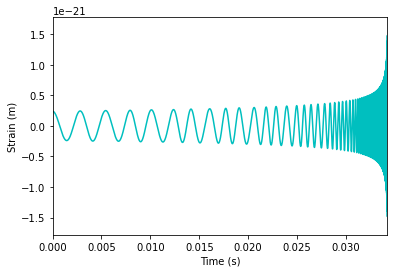

In [129]:
plt.plot(timePNsec, hplusPN, 'c-')
plt.axis([min(timesecPN), max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Comparison of Waveforms 

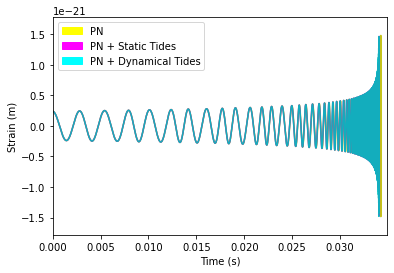

In [155]:
cyan_patch = mpatches.Patch(color='yellow', label=r'PN')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Static Tides')
yellow_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides')
plt.legend(handles=[cyan_patch, magenta_patch, yellow_patch])
plt.plot(timePNsec, hplusPN, 'y-', alpha = 0.9)
plt.plot(timePNTsec, hplusPNT, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.axis([0.0, 1.02*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNTO1-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO.png', bbox_inches='tight', dpi=200) #, dpi=300
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


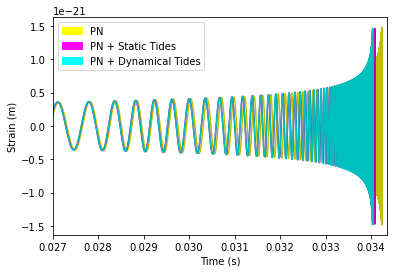

In [177]:
cyan_patch = mpatches.Patch(color='yellow', label=r'PN')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Static Tides')
yellow_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides')
plt.legend(handles=[cyan_patch, magenta_patch, yellow_patch])
plt.plot(timePNsec, hplusPN, 'y-', alpha = 1)
plt.plot(timePNTsec, hplusPNT, 'm-', alpha = 1)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 1)
plt.axis([0.027, 1.0035*max(timePNsec), 1.1*min(hplusPN), 1.1*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNTO1-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO1.png', bbox_inches='tight', dpi=200)
plt.show()

/home/irvin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/irvin/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


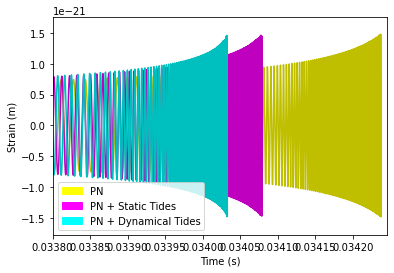

In [178]:
cyan_patch = mpatches.Patch(color='yellow', label=r'PN', alpha =1)
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Static Tides', alpha = 1)
yellow_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides', alpha = 1)
plt.legend(handles=[cyan_patch, magenta_patch, yellow_patch])
plt.plot(timePNsec, hplusPN, 'y-', alpha = 1)
plt.plot(timePNTsec, hplusPNT, 'm-', alpha = 1)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 1)
plt.axis([0.0338, 1.00025*max(timePNsec), 1.2*min(hplusPNTO), 1.2*max(hplusPNTO)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
plt.savefig('gw-PNTO2-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO2.png', bbox_inches='tight', dpi=200)
plt.show()

/home/irvin/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


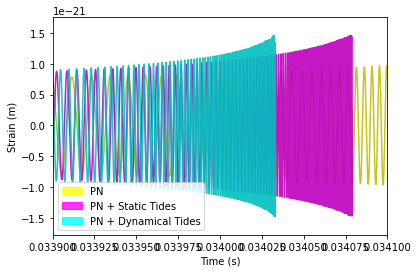

In [151]:
cyan_patch = mpatches.Patch(color='yellow', label=r'PN', alpha =0.8)
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Static Tides', alpha = 0.8)
yellow_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides', alpha = 0.8)
plt.legend(handles=[cyan_patch, magenta_patch, yellow_patch])
plt.plot(timePNsec, hplusPN, 'y-', alpha = 0.9)
plt.plot(timePNTsec, hplusPNT, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.axis([0.0339, 0.0341, 1.2*min(hplusPNTO), 1.2*max(hplusPNTO)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNTO3-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO2.png', bbox_inches='tight', dpi=200)
plt.show()

In [153]:
t1 = 0.00824
t2 = 0.00820
tt1 = t1 - t2
print(tt1)

4.0000000000000105e-05


In [154]:
t3 = 0.03407
t4 = 0.03402
tt2 = t3 - t4
print(tt2)

5.000000000000143e-05


In [179]:
tt2 - tt1

1.0000000000001327e-05

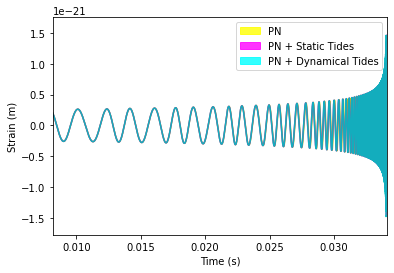

In [133]:
cyan_patch = mpatches.Patch(color='yellow', label=r'PN', alpha =0.8)
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Static Tides', alpha = 0.8)
yellow_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides', alpha = 0.8)
plt.legend(handles=[cyan_patch, magenta_patch, yellow_patch])
plt.plot(timePNsec, hplusPN, 'y-', alpha = 0.9)
plt.plot(timePNTsec, hplusPNT, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.axis([0.00815, 1.0017*max(timePNTsec), 1.2*min(hplusPNTO), 1.2*max(hplusPNTO)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNTO4-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO3.png', bbox_inches='tight', dpi=200)
plt.show()

In [101]:
print(timePNsec[-1])
print(timePNTsec[-1])
print(timePNTOsec[-1])

0.00837780445476354
0.008238553257982938
0.008193472330318556


In [140]:
print(ns.ntide)

13917.65663191198


In [ ]:
13917.656

In [146]:
minv = 13917.65662
maxv = 13917.65666

In [147]:
ns.ntide/minv

1.0000000008558898

In [148]:
maxv/ns.ntide

1.0000000020181574